# Fixing “different‑sized inputs” in parallel QPIXL

**Problem:**  
The original pipeline fails or corrupts images when two inputs have different dimensions—because the Walsh–Hadamard transform (`sfwht`) expects vectors of equal, power‑of‑2 length.

**Solution:**  
I added a helper (`pad2d_to_pow2`) to pad each image to the next square power‑of‑2, flattened in column‑major order, ran the quantum encode/decode, then reshaped back into the padded square and cropped to the original sizes. This eliminates index errors and preserves image quality.

## 1) Imports & helper

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from qiskit_aer import StatevectorSimulator
from QPIXL.qiskit.qpixl_parallel import cFRQI
import QPIXL.helper as hlp

In [5]:
# Helper: pad 2D to square power‑of‑2
def pad2d_to_pow2(img, fill=0):
    h, w = img.shape
    size = 2 ** math.ceil(math.log2(max(h, w)))
    pad_h = size - h
    pad_w = size - w
    # I pad both axes up to the same square size
    padded = np.pad(img, ((0, pad_h), (0, pad_w)), constant_values=fill)
    return padded, size

## 2) Load & resize

In [6]:
# Load & resize to grayscale arrays
img1 = np.array(
    Image.open("figures/creation_world.png")
    .convert("L")
    .resize((33, 40), Image.Resampling.LANCZOS)
)
img2 = np.array(
    Image.open("figures/cat.webp")
    .convert("L")
    .resize((41, 34), Image.Resampling.LANCZOS)
)

## 3) Pad, flatten, encode & decode

In [7]:
# Pad both (transpose first to match pipeline)
padded1, size = pad2d_to_pow2(img1.T)
padded2, _ = pad2d_to_pow2(img2.T)

# remember original shapes for cropping
shapes = [img1.shape, img2.shape]

# Flatten in column‑major (Fortran) order
np_frame = [padded1.flatten(order="F"), padded2.flatten(order="F")]

# Encode & run the circuit
qc = cFRQI(np_frame, 0)
backend = StatevectorSimulator(method="statevector")
job = backend.run(qc)
sv = np.real(job.result().get_statevector())

# Decode back to numeric frames
decoded = hlp.decodeParallelQPIXL(sv, qc, len(np_frame))

# Reshape to padded square, then crop to original
decoded_data = []
for datum, (h, w) in zip(decoded, shapes):
    # I reshape in Fortran order to the full square...
    full = np.array(datum).reshape((size, size), order="F")
    full = full.T  # transpose back
    cropped = full[:h, :w]  # then crop to (h, w)
    decoded_data.append(cropped)

## 4) Plot results

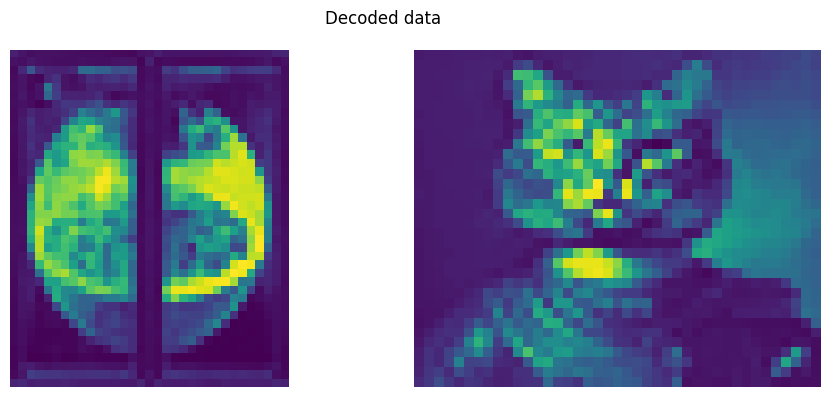

In [8]:
# Plot final results
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for i, ax in enumerate(axs):
    ax.imshow(decoded_data[i], cmap="viridis")
    ax.axis("off")
plt.suptitle("Decoded data")
plt.tight_layout()
plt.show()